In [ ]:
# %tensorflow_version 1.x

copy from https://keras.io/examples/generative/wgan_gp/

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import *

# 데이터 준비

In [ ]:
IMG_SHAPE = (28, 28, 1)
BATCH_SIZE = 512

# Size of noise vector
noise_dim = 128

fashion_mnist = keras.datasets.fashion_mnist
# (train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()
print(f"Number of examples: {len(train_images)}")
print(f"Shape of the images in the dataset: {train_images.shape[1:]}")

# we will reshape each sample to (28, 28, 1) and normalize the pixel values in [-1, 1].
train_images = train_images.reshape(train_images.shape[0], *IMG_SHAPE).astype("float32")
train_images = (train_images - 127.5) / 127.5


Number of examples: 60000
Shape of the images in the dataset: (28, 28)


In [ ]:
print(train_images.shape)
print(np.min(train_images), np.max(train_images))

(60000, 28, 28, 1)
-1.0 1.0


# D 정의

In [ ]:

def conv_block(
    x,
    filters,
    kernel_size=(3, 3),
    strides=(1, 1),
    padding="same",
    use_bias=True,
    activation=LeakyReLU(0.2),
    use_bn=False,
    use_dropout=False,
    drop_value=0.3,
):
    x = Conv2D(filters, kernel_size, strides=strides, padding=padding, use_bias=use_bias)(x)
    if use_bn:
        x = BatchNormalization()(x)
    x = activation(x)
    if use_dropout:
        x = Dropout(drop_value)(x)
    return x


def get_discriminator_model():
    img_input = Input(shape=IMG_SHAPE)
    # 사이즈를 (32, 32, 1)로 맞추어 주려고 zero padding을 함.
    x = ZeroPadding2D((2, 2))(img_input)
    x = conv_block(x, 64, (5,5), strides=(2,2), activation=LeakyReLU(0.2))
    x = conv_block(x, 128, (5,5), strides=(2,2), activation=LeakyReLU(0.2), use_dropout=True, drop_value=0.3)
    x = conv_block(x, 256, (5,5), strides=(2,2), activation=LeakyReLU(0.2), use_dropout=True, drop_value=0.3)
    x = conv_block(x, 512, (5,5), strides=(2,2), activation=LeakyReLU(0.2))
    x = Flatten()(x)
    x = Dropout(0.2)(x)
    x = Dense(1)(x)

    d_model = keras.models.Model(img_input, x, name="discriminator")
    return d_model


d_model = get_discriminator_model()
d_model.summary()


Model: "discriminator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
zero_padding2d_3 (ZeroPaddin (None, 32, 32, 1)         0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 16, 16, 64)        1664      
_________________________________________________________________
leaky_re_lu_22 (LeakyReLU)   (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 8, 8, 128)         204928    
_________________________________________________________________
leaky_re_lu_23 (LeakyReLU)   (None, 8, 8, 128)         0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 8, 8, 128)       

# G 정의

In [ ]:

def upsample_block(
    x,
    filters,
    kernel_size=(3, 3),
    strides=(1, 1),
    up_size=(2, 2),
    padding="same",
    use_bias=False,
    use_bn=True,
    activation=LeakyReLU(0.2),
    use_dropout=False,
    drop_value=0.3,
):
    x = UpSampling2D(up_size)(x)
    x = Conv2D(filters, kernel_size, strides=strides, padding=padding, use_bias=use_bias)(x)

    if use_bn:
        x = BatchNormalization()(x)

    if activation:
        x = activation(x)
    if use_dropout:
        x = Dropout(drop_value)(x)
    return x


def get_generator_model():
    noise = Input(shape=(noise_dim,))
    x = Dense(4 * 4 * 256, use_bias=False)(noise)
    x = BatchNormalization()(x)
    x = LeakyReLU(0.2)(x)

    x = Reshape((4, 4, 256))(x)
    x = upsample_block(x, 128, (3, 3))
    x = upsample_block(x, 64, (3, 3))
    x = upsample_block(x, 1, (3, 3), activation=Activation("tanh"))

    # At this point, we have an output which has the same shape as the input, (32, 32, 1).
    # We will use a Cropping2D layer to make it (28, 28, 1).
    x = Cropping2D((2, 2))(x)

    g_model = keras.models.Model(noise, x, name="generator")
    return g_model


g_model = get_generator_model()
g_model.summary()


Model: "generator"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 128)]        0                                            
__________________________________________________________________________________________________
dense_7 (Dense)                 (None, 4096)         524288      input_8[0][0]                    
__________________________________________________________________________________________________
batch_normalization_12 (BatchNo (None, 4096)         16384       dense_7[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu_27 (LeakyReLU)      (None, 4096)         0           batch_normalization_12[0][0]     
__________________________________________________________________________________________

# 전체 모델 정의

In [ ]:
class WGAN(keras.Model):
    def __init__(
        self,
        discriminator,
        generator,
        latent_dim,
        discriminator_extra_steps=3,
        gp_weight=10.0,
    ):
        super(WGAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        self.d_steps = discriminator_extra_steps
        self.gp_weight = gp_weight

    def compile(self, d_optimizer, g_optimizer, d_loss_fn, g_loss_fn):
        super(WGAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.d_loss_fn = d_loss_fn
        self.g_loss_fn = g_loss_fn

    def gradient_penalty(self, batch_size, real_images, fake_images):
        """ Calculates the gradient penalty.

        This loss is calculated on an interpolated image
        and added to the discriminator loss.
        """
        # get the interplated image
        alpha = tf.random.normal([batch_size, 1, 1, 1], 0.0, 1.0)
        diff = fake_images - real_images
        interpolated = real_images + alpha * diff

        with tf.GradientTape() as gp_tape:
            gp_tape.watch(interpolated)
            # 1. Get the discriminator output for this interpolated image.
            pred = self.discriminator(interpolated, training=True)

        # 2. Calculate the gradients w.r.t to this interpolated image.
        grads = gp_tape.gradient(pred, [interpolated])[0]
        # 3. Calcuate the norm of the gradients
        norm = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=[1, 2, 3]))
        gp = tf.reduce_mean((norm - 1.0) ** 2)
        return gp

    def train_step(self, real_images):
        if isinstance(real_images, tuple):
            real_images = real_images[0]

        batch_size = tf.shape(real_images)[0]

        # D는 G에 비해 여러번 학습
        for i in range(self.d_steps):

            # D 한번 학습
            random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
            with tf.GradientTape() as tape:
                fake_images = self.generator(random_latent_vectors, training=True)
                fake_logits = self.discriminator(fake_images, training=True)
                real_logits = self.discriminator(real_images, training=True)

                d_cost = self.d_loss_fn(real_img=real_logits, fake_img=fake_logits)
                gp = self.gradient_penalty(batch_size, real_images, fake_images)
                d_loss = d_cost + gp * self.gp_weight

            d_gradient = tape.gradient(d_loss, self.discriminator.trainable_variables)
            self.d_optimizer.apply_gradients(zip(d_gradient, self.discriminator.trainable_variables))

        # G 한번 학습
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
        with tf.GradientTape() as tape:
            generated_images = self.generator(random_latent_vectors, training=True)
            gen_img_logits = self.discriminator(generated_images, training=True)
            g_loss = self.g_loss_fn(gen_img_logits)

        gen_gradient = tape.gradient(g_loss, self.generator.trainable_variables)
        self.g_optimizer.apply_gradients(zip(gen_gradient, self.generator.trainable_variables))
        
        return {"d_loss": d_loss, "g_loss": g_loss}

        

# callback 정의


In [ ]:
import math

def show_images(images):
    n = int(math.sqrt(len(images)))
    size = images[0].shape[0]
    figure = np.zeros((size * n, size * n, 3))

    for i in range(n):
        for j in range(n):
            figure[i*size : (i+1)*size,
                   j*size : (j+1)*size] = images[i*n+j]
    figure = (figure + 1) / 2 * 255
    figure = np.round(figure, 0).astype('uint8')
    plt.imshow(figure)
    plt.show()


class GANMonitor(keras.callbacks.Callback):
    def __init__(self, num_img=81, latent_dim=noise_dim):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.normal(shape=(self.num_img, self.latent_dim))
        generated_images = self.model.generator(random_latent_vectors)
        show_images(generated_images)


# 학습


Epoch 1/20
118/118 [==============================] - ETA: 0s - d_loss: -11.8713 - g_loss: 1.5174

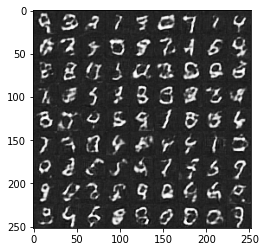

118/118 [==============================] - 170s 1s/step - d_loss: -11.8827 - g_loss: 1.5411
Epoch 2/20
118/118 [==============================] - ETA: 0s - d_loss: -10.8822 - g_loss: 5.9554

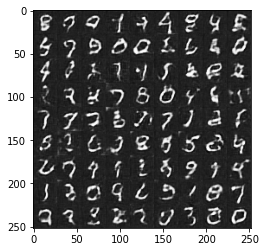

118/118 [==============================] - 169s 1s/step - d_loss: -10.8977 - g_loss: 5.9342
Epoch 3/20
118/118 [==============================] - ETA: 0s - d_loss: -9.9957 - g_loss: 9.2678

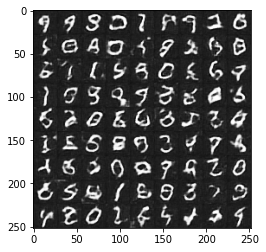

118/118 [==============================] - 170s 1s/step - d_loss: -9.9985 - g_loss: 9.2868
Epoch 4/20
118/118 [==============================] - ETA: 0s - d_loss: -9.1888 - g_loss: 9.4206

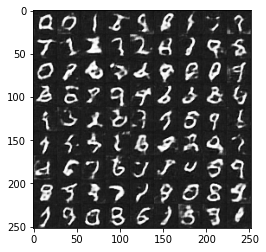

118/118 [==============================] - 170s 1s/step - d_loss: -9.1931 - g_loss: 9.3915
Epoch 5/20
118/118 [==============================] - ETA: 0s - d_loss: -8.4659 - g_loss: 9.4644

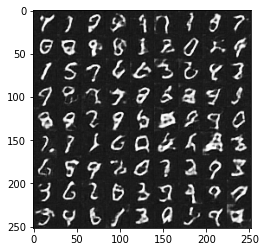

118/118 [==============================] - 170s 1s/step - d_loss: -8.4654 - g_loss: 9.4675
Epoch 6/20
118/118 [==============================] - ETA: 0s - d_loss: -7.8425 - g_loss: 10.4185

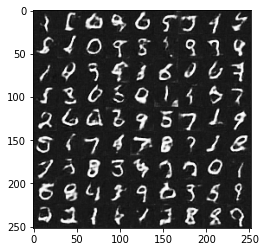

118/118 [==============================] - 169s 1s/step - d_loss: -7.8355 - g_loss: 10.4179
Epoch 7/20
118/118 [==============================] - ETA: 0s - d_loss: -7.2690 - g_loss: 10.0018

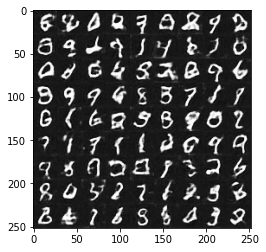

118/118 [==============================] - 169s 1s/step - d_loss: -7.2664 - g_loss: 10.0273
Epoch 8/20
118/118 [==============================] - ETA: 0s - d_loss: -6.7086 - g_loss: 10.0529

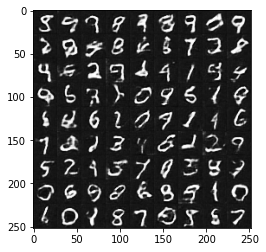

118/118 [==============================] - 170s 1s/step - d_loss: -6.7120 - g_loss: 10.0454
Epoch 9/20
118/118 [==============================] - ETA: 0s - d_loss: -6.2059 - g_loss: 11.0230

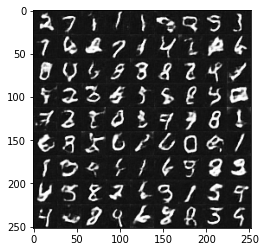

118/118 [==============================] - 170s 1s/step - d_loss: -6.1995 - g_loss: 11.0003
Epoch 10/20
118/118 [==============================] - ETA: 0s - d_loss: -5.7930 - g_loss: 10.0931

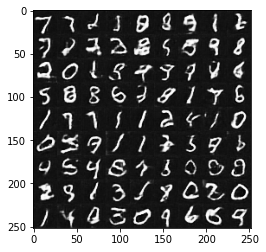

118/118 [==============================] - 170s 1s/step - d_loss: -5.7837 - g_loss: 10.1223
Epoch 11/20
118/118 [==============================] - ETA: 0s - d_loss: -5.3911 - g_loss: 9.9092

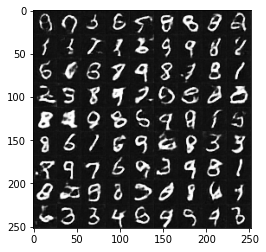

118/118 [==============================] - 170s 1s/step - d_loss: -5.3936 - g_loss: 9.9193
Epoch 12/20
118/118 [==============================] - ETA: 0s - d_loss: -4.9893 - g_loss: 9.6893

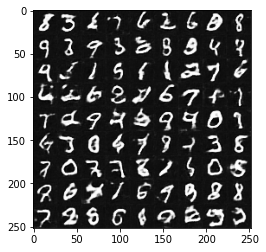

118/118 [==============================] - 170s 1s/step - d_loss: -4.9846 - g_loss: 9.7132
Epoch 13/20
118/118 [==============================] - ETA: 0s - d_loss: -4.6929 - g_loss: 11.4192

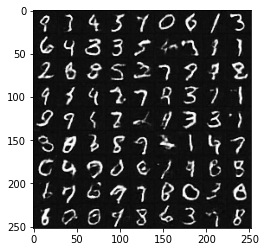

118/118 [==============================] - 169s 1s/step - d_loss: -4.6811 - g_loss: 11.4553
Epoch 14/20
118/118 [==============================] - ETA: 0s - d_loss: -4.3436 - g_loss: 13.5684

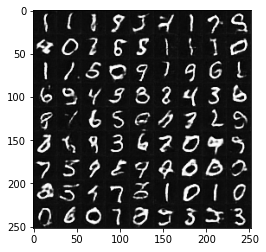

118/118 [==============================] - 170s 1s/step - d_loss: -4.3355 - g_loss: 13.5503
Epoch 15/20
118/118 [==============================] - ETA: 0s - d_loss: -4.0550 - g_loss: 12.0638

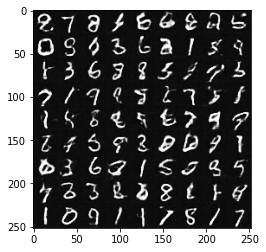

118/118 [==============================] - 170s 1s/step - d_loss: -4.0620 - g_loss: 12.0787
Epoch 16/20
118/118 [==============================] - ETA: 0s - d_loss: -3.7807 - g_loss: 13.4565

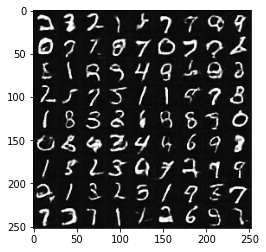

118/118 [==============================] - 170s 1s/step - d_loss: -3.7775 - g_loss: 13.4304
Epoch 17/20
118/118 [==============================] - ETA: 0s - d_loss: -3.5026 - g_loss: 11.2536

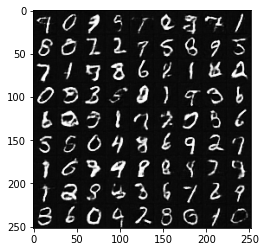

118/118 [==============================] - 170s 1s/step - d_loss: -3.4799 - g_loss: 11.2247
Epoch 18/20
118/118 [==============================] - ETA: 0s - d_loss: -3.2712 - g_loss: 12.1030

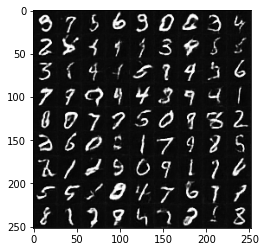

118/118 [==============================] - 170s 1s/step - d_loss: -3.2740 - g_loss: 12.1366
Epoch 19/20
118/118 [==============================] - ETA: 0s - d_loss: -3.1140 - g_loss: 12.8450

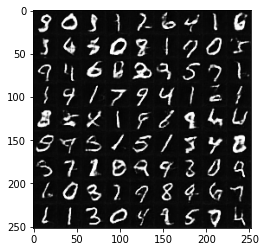

118/118 [==============================] - 170s 1s/step - d_loss: -3.1154 - g_loss: 12.8337
Epoch 20/20
118/118 [==============================] - ETA: 0s - d_loss: -2.9427 - g_loss: 9.6848

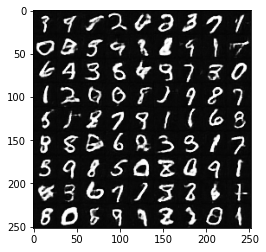

118/118 [==============================] - 170s 1s/step - d_loss: -2.9456 - g_loss: 9.6917


In [ ]:
generator_optimizer = keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5, beta_2=0.9)
discriminator_optimizer = keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5, beta_2=0.9)

def discriminator_loss(real_img, fake_img):
    real_loss = tf.reduce_mean(real_img)
    fake_loss = tf.reduce_mean(fake_img)
    return fake_loss - real_loss


def generator_loss(fake_img):
    return -tf.reduce_mean(fake_img)


epochs = 20


# Get the wgan model
wgan = WGAN(
    discriminator=d_model,
    generator=g_model,
    latent_dim=noise_dim,
    discriminator_extra_steps=3,
)

# Compile the wgan model
wgan.compile(
    d_optimizer=discriminator_optimizer,
    g_optimizer=generator_optimizer,
    g_loss_fn=generator_loss,
    d_loss_fn=discriminator_loss,
)

monitor_callback = GANMonitor(num_img=81, latent_dim=noise_dim)

# Start training
wgan.fit(train_images, batch_size=BATCH_SIZE, epochs=epochs, callbacks=[monitor_callback])
